# Overall Ramen Classification

> 학번: 2019272060

> 이름: 임현정

---

In [74]:
# 8.1

import time
import os
import copy

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
%matplotlib inline




In [75]:
# 8.2

if torch.cuda.is_available():
    device = torch.device('cuda')          
else:
    device = torch.device('cpu')
    
print('device:', device)

device: cuda


### Hyperparameters
---

In [180]:
# 8.3 하이퍼파라미터

num_epochs = 40
num_classes = 13     # 6,7
batch_size = 4      
learning_rate = 0.001

In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load dataset
---

In [190]:
# 8.5

# Training을 위한 데이터 확장과 데이터셋 정규화
# 데이터의 수가 적다고 느껴 data augumentation을 다양하게 진행함

train_transforms = transforms.Compose([ 
        transforms.RandomResizedCrop(224),  # 랜덤 리사이즈 후 크롭
        transforms.RandomHorizontalFlip(),  # 랜덤 수평 플립
        transforms.RandomHorizontalFlip(),  # 좌우반전
        transforms.RandomRotation(degrees=10), # 10도 회전
        transforms.ColorJitter(), # 색 관련 변화
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# Test를 위해서는 데이터셋 정규화만

test_transforms = transforms.Compose([
        transforms.Resize(256),             # 리사이즈
        transforms.CenterCrop(224),         # 가운데 크롭
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


In [182]:
# 8.6

# ImageFolder를 사용하여 폴더 안에 있는 이미지들을 데이터셋으로 사용

train_dataset = datasets.ImageFolder( '/content/drive/MyDrive/Overall_Ramen_dataset/train', train_transforms)
test_dataset = datasets.ImageFolder( '/content/drive/MyDrive/Overall_Ramen_dataset/test', test_transforms)

train_loader = DataLoader( train_dataset, batch_size=batch_size, shuffle=True )
test_loader = DataLoader( test_dataset, batch_size=batch_size, shuffle=True )

class_names = train_dataset.classes
print(class_names)


['Jin_ramen', 'anseong-tangmyeon', 'baeg-myeon', 'chamkkae-ramen', 'cheese-bokki', 'hong-myeon', 'kkokko-myeon', 'nagasakki-jjamppong', 'neoguli', 'sali-gomtang', 'shin-ramen', 'twigim-udong', 'yukgaejang']


### Preview data

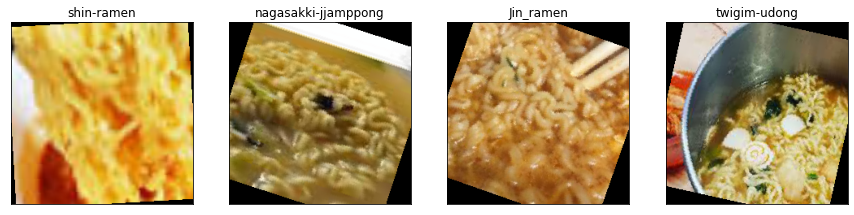

In [191]:
# 8.7 데이터 미리보기

def convert_to_imshow_format(image):
   
    # from 3 x Height x Width to Height x Width x 3
    image = image.numpy().transpose(1,2,0)

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # convert back to [0,1] range from [-1,1] range
    image = image * std + mean
    image = np.clip(image, 0, 1)
    
    return image

dataiter = iter(train_loader)
images, labels = dataiter.next()
images, labels = images[:6], labels[:6]


plt.rc('font', family='NanumBarunGothic') 
fig, axes = plt.subplots(1, len(images), figsize=(15,4))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(class_names[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

### Progress monitor
---

In [192]:
# 8.8

from IPython.display import HTML, display

# Custom IPython progress bar for training
class ProgressMonitor(object):
    
    tmpl = """
        <table style="width: 100%;">
            <tbody>
                <tr>
                    <td style="width: 30%;">
                     <b>Epoch: {epoch}/{num_epochs} Loss: {loss:0.4f}</b> &nbsp&nbsp&nbsp {value} / {length}
                    </td>
                    <td style="width: 70%;">
                        <progress value='{value}' max='{length}', style='width: 100%'>{value}</progress>
                    </td>
                </tr>
            </tbody>
        </table>        
        """

    def __init__(self, length):
        self.length = length
        self.count = 0
        self.display = display(self.html(0, 0, 0, 0), display_id=True)
        
    def html(self, count, loss, epoch, num_epochs):
        return HTML(self.tmpl.format(length=self.length, value=count, loss=loss, epoch=epoch, num_epochs=num_epochs))
        
    def update(self, epoch, num_epochs, count, loss):
        self.count += count
        self.display.update(self.html(self.count, loss, epoch, num_epochs))

### Finetuning the convnet
___

In [193]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)
# alexnet = models.alexnet(pretrained=True)
# vgg16 = models.vgg16(pretrained=True)
# squeezenet1_0 = models.squeezenet1_0(pretrained=True)
# googlenet = models.googlenet(pretrained=True)

print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [194]:
# 8.9 Finetuning 
model_ft = models.resnet18(pretrained=True)
model_ft.fc = nn.Linear(512, num_classes)

model_ft = model_ft.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9) 
lr_scheduler_ft = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.2) # learning rate dacay




In [ ]:
# Finetuning codes
# resnet18        1. model.fc = nn.Linear(512, num_classes) 
# alexnet         2. model.classifier[6] = nn.Linear(4096,num_classes)
# vgg16           3. model.classifier[6] = nn.Linear(4096,num_classes)
# squeezenet1_0   4. model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
# googlenet       5. model.fc = nn.Linear(1024, num_classes)

In [87]:
# 8.10  Fixed feature extractor
model_ft = models.resnet18(pretrained=True)
for param in model_ft.parameters():
  param.requires_grad = False
model_ft.fc = nn.Linear(model_ft.fc.in_features,num_classes) 
model_ft = model_ft.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9) 
lr_scheduler_ft = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.2) # learning rate dacay



### Train
---

In [195]:
# 8.11 Train

def train(epoch, num_epochs, model, optimizer, scheduler):

    # train phase
    model.train()
    
    # create a progress bar
    batch_loss_list = []
    progress = ProgressMonitor(length=len(train_dataset))

    for batch, target in train_loader:
        # Move the training data to the GPU
        batch, target = batch.to(device), target.to(device)

        # forward propagation
        output = model( batch )

        # calculate the loss
        loss = loss_func( output, target )
        
        # clear previous gradient computation
        optimizer.zero_grad()
 
        # backpropagate to compute gradients
        loss.backward()
 
        # update model weights
        optimizer.step()

        # update progress bar
        batch_loss_list.append(loss.item())
        progress.update(epoch, num_epochs, batch.shape[0], sum(batch_loss_list)/len(batch_loss_list) )

    # 스케쥴러의 스텝을 증가 - 때가 되면 학습률 변경
    if scheduler:
        scheduler.step()

        

In [196]:
# 8.12 Test

def test(model):
    # test phase
    model.eval()

    correct = 0
    
    # We don't need gradients for test, so wrap in 
    # no_grad to save memory
    with torch.no_grad():
        for batch, target in test_loader:
            # Move the training batch to the GPU
            batch, target = batch.to(device), target.to(device)

            # forward propagation
            output = model( batch )

            # get prediction
            output = torch.argmax(output, 1)

            # accumulate correct number
            correct += (output == target).sum().item()

    # Calculate test accuracy    
    acc = 100 * float(correct) / len(test_dataset) 
    print( 'Test Acc: {}/{} ({:.2f}%)'.format( correct, len(test_dataset), acc ) )  
    
    return acc

In [197]:
# 8.13

since = time.time()

# initialize the best weights
best_model_weights = copy.deepcopy( model_ft.state_dict() )
best_acc = 0.0

for epoch in range(num_epochs):

    # train
    train(epoch+1, num_epochs, model_ft, optimizer_ft, lr_scheduler_ft )
    # test
    acc = test(model_ft)

    # update the best weights
    if acc > best_acc:
        best_acc = acc
        best_model_weights = copy.deepcopy( model_ft.state_dict() )

# load the best weights
model_ft.load_state_dict( best_model_weights )

# summary
time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best test accuracy: {:4f}'.format(best_acc))



Epoch: 1/40 Loss: 2.6112 346 / 346,346


Test Acc: 34/128 (26.56%)


Epoch: 2/40 Loss: 2.2055 346 / 346,346


Test Acc: 53/128 (41.41%)


Epoch: 3/40 Loss: 1.8579 346 / 346,346


Test Acc: 67/128 (52.34%)


Epoch: 4/40 Loss: 1.7179 346 / 346,346


Test Acc: 80/128 (62.50%)


Epoch: 5/40 Loss: 1.7007 346 / 346,346


Test Acc: 74/128 (57.81%)


Epoch: 6/40 Loss: 1.5491 346 / 346,346


Test Acc: 76/128 (59.38%)


Epoch: 7/40 Loss: 1.6019 346 / 346,346


Test Acc: 81/128 (63.28%)


Epoch: 8/40 Loss: 1.2747 346 / 346,346


Test Acc: 83/128 (64.84%)


Epoch: 9/40 Loss: 1.1853 346 / 346,346


Test Acc: 90/128 (70.31%)


Epoch: 10/40 Loss: 1.1474 346 / 346,346


Test Acc: 94/128 (73.44%)


Epoch: 11/40 Loss: 1.1568 346 / 346,346


Test Acc: 94/128 (73.44%)


Epoch: 12/40 Loss: 1.0028 346 / 346,346


Test Acc: 92/128 (71.88%)


Epoch: 13/40 Loss: 0.9796 346 / 346,346


Test Acc: 89/128 (69.53%)


Epoch: 14/40 Loss: 0.9989 346 / 346,346


Test Acc: 87/128 (67.97%)


Epoch: 15/40 Loss: 0.8944 346 / 346,346


Test Acc: 86/128 (67.19%)


Epoch: 16/40 Loss: 0.9526 346 / 346,346


Test Acc: 91/128 (71.09%)


Epoch: 17/40 Loss: 1.0126 346 / 346,346


Test Acc: 89/128 (69.53%)


Epoch: 18/40 Loss: 0.9553 346 / 346,346


Test Acc: 92/128 (71.88%)


Epoch: 19/40 Loss: 0.9314 346 / 346,346


Test Acc: 91/128 (71.09%)


Epoch: 20/40 Loss: 0.9874 346 / 346,346


Test Acc: 92/128 (71.88%)


Epoch: 21/40 Loss: 0.8581 346 / 346,346


Test Acc: 92/128 (71.88%)


Epoch: 22/40 Loss: 0.9514 346 / 346,346


Test Acc: 91/128 (71.09%)


Epoch: 23/40 Loss: 0.9350 346 / 346,346


Test Acc: 90/128 (70.31%)


Epoch: 24/40 Loss: 0.9291 346 / 346,346


Test Acc: 93/128 (72.66%)


Epoch: 25/40 Loss: 0.8639 346 / 346,346


Test Acc: 93/128 (72.66%)


Epoch: 26/40 Loss: 0.9483 346 / 346,346


Test Acc: 91/128 (71.09%)


Epoch: 27/40 Loss: 0.9527 346 / 346,346


Test Acc: 89/128 (69.53%)


Epoch: 28/40 Loss: 0.8612 346 / 346,346


Test Acc: 95/128 (74.22%)


Epoch: 29/40 Loss: 0.9141 346 / 346,346


Test Acc: 94/128 (73.44%)


Epoch: 30/40 Loss: 0.8260 346 / 346,346


Test Acc: 92/128 (71.88%)


Epoch: 31/40 Loss: 0.9222 346 / 346,346


Test Acc: 93/128 (72.66%)


Epoch: 32/40 Loss: 0.9585 346 / 346,346


Test Acc: 89/128 (69.53%)


Epoch: 33/40 Loss: 0.9129 346 / 346,346


Test Acc: 94/128 (73.44%)


Epoch: 34/40 Loss: 0.8984 346 / 346,346


Test Acc: 92/128 (71.88%)


Epoch: 35/40 Loss: 0.8001 346 / 346,346


Test Acc: 92/128 (71.88%)


Epoch: 36/40 Loss: 0.8998 346 / 346,346


Test Acc: 90/128 (70.31%)


Epoch: 37/40 Loss: 0.8337 346 / 346,346


Test Acc: 93/128 (72.66%)


Epoch: 38/40 Loss: 0.9092 346 / 346,346


Test Acc: 94/128 (73.44%)


Epoch: 39/40 Loss: 0.9381 346 / 346,346


Test Acc: 92/128 (71.88%)


Epoch: 40/40 Loss: 0.9208 346 / 346,346


Test Acc: 94/128 (73.44%)
Training completed in 2m 44s
Best test accuracy: 74.218750


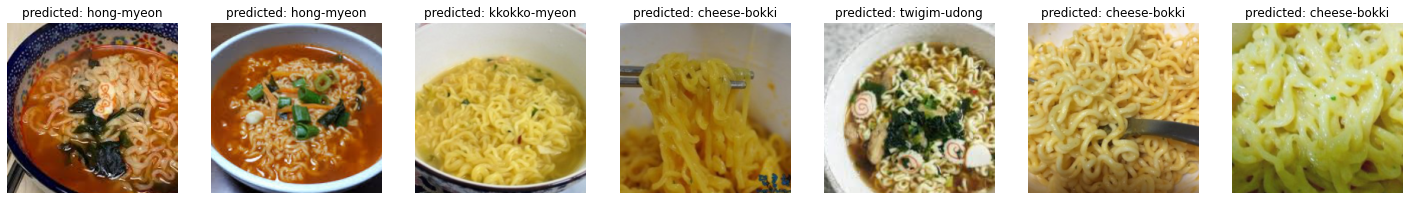

In [179]:
# 8.14

def visualize_model(model, num_images=7):
    was_training = model.training
    model.eval()
    images_so_far = 0
    
    fig = plt.figure(figsize=(25,25))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(1, num_images, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                ax.imshow( convert_to_imshow_format(inputs.cpu().data[j]) )

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

        

visualize_model(model_ft)        